# Using digital elevation model differencing to estimate micro-topographical changes to a road
## Working with project data

### Objective
Difference digital elevation models from two sites at different slices in time to observe the development of wheel ruts and other micro-topographical features

### Datasets
The datasets used here are from unmanned aerial vehicle (UAV) surveys carried out from 11/09/2020 to 06/01/2022 on two 80-meter segments of gravel forest road in western Washington state. These datasets were collected at least every four months, if not more frequently.
___
First, we'll do some basic setup.

In [11]:
# Import packages
from osgeo import gdal 
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import rioxarray as rioxarray
import geopandas as gpd

# Set parameter for animation
plt.rcParams["animation.html"] = "html5"

# Import pretty print
from pprint import pprint

In [2]:
# Show plots in the notebook
%matplotlib inline

In [3]:
# Define datasets
MEL14_20220428 = '../MEL14_data/20220428_clipped3.tif'
MEL14_20220309 = '../MEL14_data/20220309_clipped2.tif'

In [7]:
#!gdalinfo $MEL14_20220428

In [19]:
#!gdaladdo -r gauss $MEL14_20220309

0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
!gdalinfo $MEL14_20220309

Driver: GTiff/GeoTIFF
Files: ../MEL14_data/20220309_clipped2.tif
Size is 1090, 8810
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG

In [21]:
da_ov5_1 = rioxarray.open_rasterio(MEL14_20220428, overview_level = 5, mask_and_scale = True).squeeze()
da_ov5_2 = rioxarray.open_rasterio(MEL14_20220309, overview_level = 5, mask_and_scale = True).squeeze()



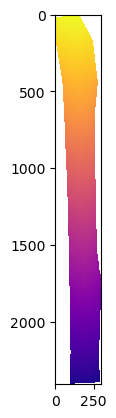

In [20]:
plt.imshow(da1, cmap = 'plasma')

In [9]:
mask_path = '../MEL14_data/mask.shp'

In [15]:
mask_gdf = gpd.read_file(mask_path)
mask_gdf

,id,name,geometry
0,1,mask,"POLYGON ((4989.236 5082.146, 4993.916 5083.198..."


In [23]:
#clipping using rioxarray
da1_clipped = da_ov5_1.rio.clip(mask_gdf.geometry)
da2_clipped = da_ov5_2.rio.clip(mask_gdf.geometry)

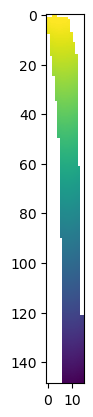

In [31]:
#reprojecting and matching
da2_clipped_proj = da2_clipped.rio.reproject_match(da1_clipped, resampling = 3)
plt.imshow(da2_clipped_proj)

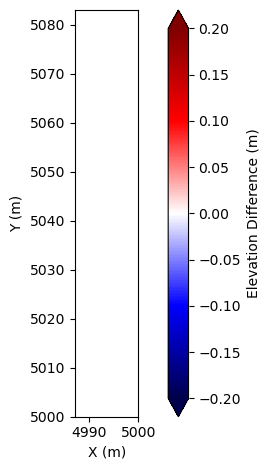

In [30]:
diff = da2_clipped_proj-da1_clipped

f, ax = plt.subplots()
plt.imshow(diff, cmap = 'seismic', vmin= -0.2, vmax=0.2)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_xlim(4987, 5000)
ax.set_ylim(5000, 5083)
plt.tight_layout()
plt.savefig('Difference_MEL.png', bbox_inches='tight', dpi=300)
plt.show()

We can open the datasets using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package:

In [17]:
KID13_nov = rio.open(KID13_20201109)
KID13_feb = rio.open(KID13_20210208)

Let's look at the profiles for these datasets.

In [18]:
pprint(KID13_nov.profile)
pprint(KID13_feb.profile)

{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 15351,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.006419992325402788, 0.0, 4987.076,
       0.0, -0.006419998697153266, 5104.8759),
 'width': 2606}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 15016,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.006339975399753869, 0.0, 4984.9834,
       0.0, -0.006339997336174742, 5103.2018),
 'width': 3252}


We can see that while the projections are the same, the resolutions and extents are not. To be able to difference the DEMs, we will need to ensure that they are the same projection, resolution, and extent.

We'll load the DEMs as arrays and plot them so we can see this graphically.

In [19]:
# Read in the DEMs
KID13_nov_np = KID13_nov.read(1)
KID13_feb_np = KID13_feb.read(1)

# Mask nodata values
KID13_nov_mask = np.ma.masked_values(KID13_nov_np, -10000.0)
KID13_feb_mask = np.ma.masked_values(KID13_feb_np, -10000.0)

In [20]:
# Define the figure and plot as animation for clarity
fig, ax = plt.subplots()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

im1 = plt.imshow(KID13_nov_mask)
im2 = plt.imshow(KID13_feb_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('KID 13 Nov - Feb', fontweight='bold')

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

We can see that the datasets cannot be differenced as they are currently.

To ensure the same projection, resolution, and extent, we can use the [`gdalwarp`](https://www.gdal.org/gdalwarp.html) command line utility. Below you'll see that instead of defining a normal rectangular extent using (right, bottom, left, top), I'm clipping the datasets to pre-defined shapefiles.

**Note:** I'm using the single `gdalwarp` command line utility here because I have only four rasters. If I had, say, 100 rasters, I would be much better off creating a shell script or using a `gdal` Python API.

In [21]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline ./KID13_data/Shapefiles/KID13_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        ./KID13_data/KID13_20201109_proj.tif ./KID13_data/KID13_nov_reproj.tif

Creating output file that is 1236P x 8311L.
Processing ./KID13_data/KID13_20201109_proj.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./KID13_data/KID13_20201109_proj.tif.
Copying nodata values from source ./KID13_data/KID13_20201109_proj.tif to destination ./KID13_data/KID13_nov_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline ./KID13_data/Shapefiles/KID13_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        ./KID13_data/KID13_20210208_proj.tif ./KID13_data/KID13_feb_reproj.tif

Creating output file that is 1236P x 8311L.
Processing ./KID13_data/KID13_20210208_proj.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./KID13_data/KID13_20210208_proj.tif.
Copying nodata values from source ./KID13_data/KID13_20210208_proj.tif to destination ./KID13_data/KID13_feb_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now that we have DEMs that are the same projection, extent, and resolution, let's look at them.

In [23]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - CUH
KID13_nov_proj = rio.open('./KID13_data/KID13_nov_reproj.tif')
pprint(KID13_nov_proj.profile)
KID13_nov_proj_read = KID13_nov_proj.read(1)
KID13_nov_proj_mask = np.ma.masked_values(KID13_nov_proj_read, -10000.)
KID13_nov_proj.close()

KID13_feb_proj  = rio.open('./KID13_data/KID13_feb_reproj.tif')
pprint(KID13_feb_proj.profile)
KID13_feb_proj_read = KID13_feb_proj.read(1)
KID13_feb_proj_mask = np.ma.masked_values(KID13_feb_proj_read, -10000.)
KID13_feb_proj.close()

{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8311,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.834808077358,
       0.0, -0.01, 5097.191270051388),
 'width': 1236}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8311,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.834808077358,
       0.0, -0.01, 5097.191270051388),
 'width': 1236}


In [24]:
# Define plotting extent, then plot as animation for clarity - CUH
KID13_nov_extent = rio.plot.plotting_extent(KID13_nov_proj)
KID13_feb_extent = rio.plot.plotting_extent(KID13_feb_proj)

fig, ax = plt.subplots()
im1 = plt.imshow(KID13_nov_proj_mask, extent=KID13_nov_extent)
im2 = plt.imshow(KID13_feb_proj_mask, extent=KID13_feb_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('KID13', fontweight='bold')

ims = [[im1], [im2]]


anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

Excellent! Our DEMs for each site now match. Let's difference them and plot the output:

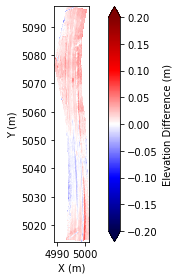

In [25]:
difference_KID13 = (KID13_feb_proj_mask-KID13_nov_proj_mask)

fig, ax = plt.subplots()
plt.imshow(difference_KID13, cmap = 'seismic', vmin= -0.2, vmax=0.2, extent=KID13_nov_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
plt.tight_layout()
plt.savefig('Difference_KID.png', bbox_inches='tight', dpi=300)
plt.show()

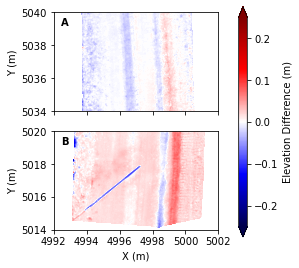

In [85]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

im = ax1.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
ax1.set_xlim(4992,5002)
ax1.set_ylim(5034,5040)
ax1.set_ylabel('Y (m)')

ax2.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
ax2.set_xlim(4992,5002)
ax2.set_ylim(5014,5020)

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')


cb_ax = fig.add_axes([0.75, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label='Elevation Difference (m)', extend='both')

ax1.text(0.07, 0.95, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)
ax2.text(0.07, 0.95, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax2.transAxes)

#fig.colorbar(ax=ax1,label='Elevation Difference (m)', extend='both')
#plt.tight_layout()
plt.savefig('Difference_zoom.png', bbox_inches='tight', dpi=300)
plt.show()

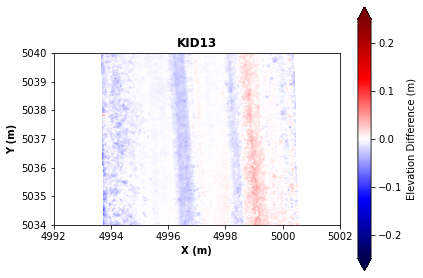

In [79]:
fig, ax = plt.subplots()
plt.imshow(difference_KID13, cmap = 'seismic', vmin= -0.25, vmax=0.25, extent=KID13_nov_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

ax.set_xlim(4992,5002)
ax.set_ylim(5034,5040)
ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('KID13', fontweight='bold')
plt.tight_layout()
plt.savefig('Difference_zoomMid.png', bbox_inches='tight', dpi=300)
plt.show()

In [3]:
# # Define datasets
# MEL14_20220309 = 'C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif'
# MEL14_20220428 = 'C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif'

We can open the datasets using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package:

In [5]:
MEL14_0309 = rio.open(MEL14_20220309)
MEL14_0428 = rio.open(MEL14_20220428)

Let's look at the profiles for these datasets.

In [6]:
pprint(MEL14_0309.profile)
pprint(MEL14_0428.profile)

{'blockysize': 1,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8810,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.009459980382541014, 0.0, 4988.352651642962,
       0.0, -0.009460004064627514, 5083.969000345493),
 'width': 1090}
{'blockysize': 1,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 9635,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.008649975597852305, 0.0, 4988.349090922401,
       0.0, -0.008650004561627622, 5083.967099863151),
 'width': 1193}


We can see that while the projections are the same, the resolutions and extents are not. To be able to difference the DEMs, we will need to ensure that they are the same projection, resolution, and extent.

We'll load the DEMs as arrays and plot them so we can see this graphically.

In [7]:
# Read in the DEMs
MEL14_0309_np = MEL14_0309.read(1)
MEL14_0428_np = MEL14_0428.read(1)

# Mask nodata values
MEL14_0309_mask = np.ma.masked_values(MEL14_0309_np, -10000.0)
MEL14_0428_mask = np.ma.masked_values(MEL14_0428_np, -10000.0)

In [8]:
# Define the figure and plot as animation for clarity
fig1, ax1 = plt.subplots()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 

im1 = plt.imshow(MEL14_0309_mask)
im2 = plt.imshow(MEL14_0428_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('MEL-14 20220309-20220428', fontweight='bold')

anim1 = animation.ArtistAnimation(fig1, ims, interval=2000, repeat_delay=1000)
plt.close()

anim1

RuntimeError: Requested MovieWriter (ffmpeg) not available

We can see that the datasets cannot be differenced as they are currently.

To ensure the same projection, resolution, and extent, we can use the [`gdalwarp`](https://www.gdal.org/gdalwarp.html) command line utility. Below you'll see that instead of defining a normal rectangular extent using (right, bottom, left, top), I'm clipping the datasets to pre-defined shapefiles.

**Note:** I'm using the single `gdalwarp` command line utility here because I have only four rasters. If I had, say, 100 rasters, I would be much better off creating a shell script or using a `gdal` Python API.

In [8]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif

Creating output file that is 1032P x 8335L.
Processing C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif.
Copying nodata values from source C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220309_clipped2.tif to destination C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
!gdalwarp -of GTiff -s_srs EPSG:32610 -t_srs EPSG:32610 -cutline C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_UTM.shp -crop_to_cutline\
        -tr 0.01 0.01 -r med -overwrite -multi \
        C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif

Creating output file that is 1032P x 8335L.
Processing C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif.
Copying nodata values from source C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/20220428_clipped3.tif to destination C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now that we have DEMs that are the same projection, extent, and resolution, let's look at them.

In [10]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - CUH
MEL14_20220309_reproj = rio.open('C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220309_reproj.tif')
pprint(MEL14_20220309_reproj.profile)
MEL14_20220309_reproj_read = MEL14_20220309_reproj.read(1)
MEL14_20220309_reproj_mask = np.ma.masked_values(MEL14_20220309_reproj_read, -10000.)
MEL14_20220309_reproj.close()

MEL14_20220428_reproj  = rio.open('C:/Users/wittkol/Documents/GitHub/micro_dem_differencing/MEL14_data/MEL14_20220428_reproj.tif')
pprint(MEL14_20220428_reproj.profile)
MEL14_20220428_reproj_read = MEL14_20220428_reproj.read(1)
MEL14_20220428_reproj_mask = np.ma.masked_values(MEL14_20220428_reproj_read, -10000.)
MEL14_20220428_reproj.close()


{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8335,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.348838527598,
       0.0, -0.01, 5083.972941589739),
 'width': 1032}
{'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 8335,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.01, 0.0, 4988.348838527598,
       0.0, -0.01, 5083.972941589739),
 'width': 1032}


In [11]:
# Define plotting extent, then plot as animation for clarity - CUH
MEL14_20220309_reproj_extent = rio.plot.plotting_extent(MEL14_20220309_reproj)
MEL14_20220428_reproj_extent = rio.plot.plotting_extent(MEL14_20220428_reproj)

fig, ax = plt.subplots()
im1 = plt.imshow(MEL14_20220309_reproj_mask, extent=MEL14_20220309_reproj_extent)
im2 = plt.imshow(MEL14_20220428_reproj_mask, extent=MEL14_20220428_reproj_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('MEL14', fontweight='bold')

ims = [[im1], [im2]]


anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

Excellent! Our DEMs for each site now match. Let's difference them and plot the output:

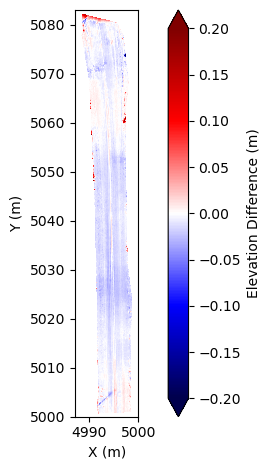

In [12]:
difference_MEL14 = (MEL14_20220428_reproj_mask-MEL14_20220309_reproj_mask)

fig, ax = plt.subplots()
plt.imshow(difference_MEL14, cmap = 'seismic', vmin= -0.2, vmax=0.2, extent=MEL14_20220428_reproj_extent)
plt.colorbar(label='Elevation Difference (m)', extend='both')

#ax.text(0.175, 0.08, 'B',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#ax.text(0.175, 0.3, 'A',fontweight='bold', horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_xlim(4987, 5000)
ax.set_ylim(5000, 5083)
plt.tight_layout()
plt.savefig('Difference_MEL.png', bbox_inches='tight', dpi=300)
plt.show()